In [1]:
from app import prompt
from langchain.schema import SystemMessage, HumanMessage

In [2]:
system_prompt = prompt.EXPANDER_PROMPT

In [3]:
from langchain.chat_models import init_chat_model

from tools import RESEARCH_TOOLS_LIST

from dotenv import load_dotenv

from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from app.models import RetrieverState

load_dotenv()

True

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from app.main import graph, subgraph
from langchain.schema import SystemMessage, HumanMessage

In [4]:
res = graph.invoke({"messages": [HumanMessage(content="WW1")]})

In [6]:
res["transcript"]

'Picture this: A 19-year-old kid takes a wrong turn in Sarajevo, pulls out a pistol, and fires two shots that echo around the world for four years. Those bullets didn\'t just kill an archduke – they shattered an entire world order and plunged humanity into its first truly global catastrophe.\n\nWelcome to today\'s deep dive into World War One – the war that was supposed to end all wars, but instead became the bloody prologue to an even bloodier century.\n\nI\'m fascinated by how quickly everything unraveled in 1914. Think about it – Europe had enjoyed relative peace for nearly a century. Sure, there were tensions, colonial squabbles, an arms race here and there. But nothing that suggested the entire continent was about to tear itself apart.\n\nYet beneath that veneer of civilization, something sinister was brewing. It was like watching a pressure cooker slowly building steam. You had this rising German Empire flexing its industrial muscles, making everyone nervous. The old Ottoman Empi

In [7]:
from tools.audio_editors import tts

In [14]:
from elevenlabs import ElevenLabs
import os

client = ElevenLabs(
    api_key=os.getenv("ELEVENLABS_API_KEY"),
)
res = client.text_to_speech.convert(
    voice_id="nPczCjzI2devNBz1zQrb",
    output_format="mp3_44100_128",
    text="The first move is what sets everything in motion.",
    model_id="eleven_multilingual_v2",
)


In [7]:
from IPython.display import Audio

# If you've saved it as "output.mp3"
Audio("output/3bddcca7796746258b3323616c889688.mp3")


In [21]:
from elevenlabs import ElevenLabs
import os
from uuid import uuid4

def tts(text: str) -> str:
    """Converts a given text to realistic speech and returns the saved audio."""
    generator = client.text_to_speech.convert(
        voice_id="nPczCjzI2devNBz1zQrb",
        output_format="mp3_44100_128",
        text="The first move is what sets everything in motion.",
        model_id="eleven_multilingual_v2",
    )
    filepath = f"{uuid4().hex}.mp3"
    with open(filepath, 'wb') as f:
            for chunk in generator:
                f.write(chunk)
    return filepath

In [20]:
uuid4().hex

'fdc8c6f8ed4d4d8c83ce09462d90a1fa'

In [15]:
def save_mp3_from_generator(generator, filename):
    with open(filename, 'wb') as f:
        for chunk in generator:
            f.write(chunk)

# Example usage
# Assuming `tts_generator` is your generator from the TTS API:
save_mp3_from_generator(res, 'output.mp3')


In [4]:
MODEL_NAME = "gpt-4.1-mini-2025-04-14"


llm = init_chat_model(model=MODEL_NAME, temperature=0.1)

llm_with_tools = llm.bind_tools(RESEARCH_TOOLS_LIST)

In [6]:
def generate_response(state: RetrieverState):
    response = llm_with_tools.invoke(state["messages"])
    if response.content:
        return {"messages": response, "researched_contents": response.content}
    return {"messages": response}

In [7]:
graph_builder = StateGraph(RetrieverState)
graph_builder.add_node("chatbot", generate_response)

tool_node = ToolNode(tools=RESEARCH_TOOLS_LIST)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

In [8]:
for s in graph.stream({"messages": [SystemMessage(content=system_prompt), HumanMessage(content="history of human evolution")]}):
    print(s)

{'chatbot': {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2xnnwl7VoTmuRS3GOytBhqtS', 'function': {'arguments': '{"query": "Human evolution"}', 'name': 'wikipedia'}, 'type': 'function'}, {'id': 'call_J2pRODHDO1PisgBIFP63Avuu', 'function': {'arguments': '{"query": "history of human evolution timeline"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_iyD4e8aSWAf2vIK0S0bE4F3w', 'function': {'arguments': '{"query": "key discoveries in human evolution history"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_PDFqBWr33N0ZtGxCrevxA6WI', 'function': {'arguments': '{"query": "surprising facts about human evolution"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1397, 'total_tokens': 1489, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_to

In [12]:
print(s["chatbot"]["researched_contents"])

<RETRIEVED_DOCS>Homo sapiens is a distinct species of the hominid family of primates, which also includes all the great apes. Over their evolutionary history, humans gradually developed traits such as bipedalism, dexterity, and complex language, as well as interbreeding with other hominins (a tribe of the African hominid subfamily), indicating that human evolution was not linear but weblike. The study of the origins of humans involves several scientific disciplines, including physical and evolutionary anthropology, paleontology, and genetics; the field is also known by the terms anthropogeny, anthropogenesis, and anthropogony—with the latter two sometimes used to refer to the related subject of hominization.
Primates diverged from other mammals about 85 million years ago (mya), in the Late Cretaceous period, with their earliest fossils appearing over 55 mya, during the Paleocene. Primates produced successive clades leading to the ape superfamily, which gave rise to the hominid and the 

In [40]:
states = []
for state in graph.get_state_history({}):
    print(state)
    print('--')
    states.append(state)

ValueError: No checkpointer set

In [13]:
from app.nodes import retriever_node, organizer_node, podcaster_node, RESEARCH_TOOLS_NODE
graph_builder = StateGraph(RetrieverState)
graph_builder.add_node("retriever", retriever_node)

graph_builder.add_node("tools", RESEARCH_TOOLS_NODE)

graph_builder.add_conditional_edges(
    "retriever",
    tools_condition,
)
graph_builder.add_edge("tools", "retriever")
graph_builder.add_edge(START, "retriever")

graph = graph_builder.compile()

In [22]:
from app.models import OrganizerState
from app.nodes import retriever_node, organizer_node, podcaster_node, RESEARCH_TOOLS_NODE

graph_builder = StateGraph(RetrieverState)
graph_builder.add_node("retriever", retriever_node)
graph_builder.add_node("tools", RESEARCH_TOOLS_NODE)
graph_builder.add_conditional_edges("retriever", tools_condition)
graph_builder.add_edge("tools", "retriever")
graph_builder.add_edge(START, "retriever")

# Do not compile yet
subgraph = graph_builder.compile()

# Build the second graph (parent graph)
graph_builder2 = StateGraph(OrganizerState)
graph_builder2.add_node("organizer", organizer_node)
graph_builder2.add_node("podcaster", podcaster_node)
graph_builder2.add_edge("organizer", "podcaster")

# Add the subgraph as a node in the parent graph
graph_builder2.add_node("retriever_subgraph", subgraph)
graph_builder2.add_edge("retriever_subgraph", "organizer")

# Define the start node
graph_builder2.add_edge(START, "retriever_subgraph")

# Now compile the parent graph
graph2 = graph_builder2.compile()

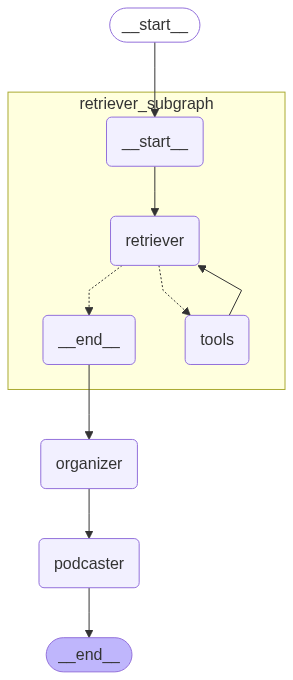

In [21]:
from IPython.display import Image, display

# Assuming 'graph' is your compiled StateGraph
display(Image(graph2.get_graph(xray=True).draw_mermaid_png()))
